# Estudo sobre o ajuste de modelos supervisionados via Aprendizado por Reforço com Feedback Humano

O projeto pode ser descrito nas seguintes três etapas:

1. Treinamento de um classificador (via aprendizado supervisionado)
2. Construção de uma base de dados de preferências e treinamento da função recompensa (via aprendizado supervisionado)
3. Ajuste fino do classificador, usando a função recompensa que reflete preferências humanas (via aprendizado por reforço)

In [ ]:
#@title config

colab=True # se esta rodando no colab ou em ambiente local

if colab:
    !pip install ipympl
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    import os
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams['axes.grid'] = False

from tqdm.notebook import tqdm, trange

import ipywidgets as widgets
from ipywidgets import interact
%matplotlib widget

import tensorflow as tf

In [ ]:
#@title carrega dados

if colab:
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
else:
    data = np.load('mnist.npz')
    data.files
    x_test = data['x_test']
    x_train = data['x_train']
    y_train = data['y_train']
    y_test = data['y_test']

x_test = x_test/255
x_train = x_train/255

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
#@title seleciona apenas digitos 4, 7 e 9

digitos_selecionados = [4, 7, 9]
N_digitos = len(digitos_selecionados)

itr = y_train==-1
ite = y_test==-1

# selecionando os digitos e reindexando
for i in range(N_digitos):
    d = digitos_selecionados[i]
    # treino
    idx = y_train==d
    itr |= idx
    y_train[idx] = i
    # teste
    idx = y_test==d
    ite |= idx
    y_test[idx] = i


x_train = x_train[itr]
y_train = y_train[itr]

x_test = x_test[ite]
y_test = y_test[ite]

print(f'selecionados:\ntreino={np.sum(itr)}\nteste={np.sum(ite)}')

selecionados:
treino=18056
teste=3019


# Etapa 1: Treinando o classificador inicial (via aprendizado supervisionado)

In [ ]:
#@title Rede classificadora
dim_var_latente = 2

input_img = tf.keras.layers.Input((28,28,1), name='input_img')
x = tf.keras.layers.Conv2D(8, kernel_size=3, activation='relu')(input_img)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Conv2D(4, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPool2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
encoded = tf.keras.layers.Dense(3, activation='softmax')(x)

modelo_sl = tf.keras.Model(input_img, encoded, name='classificador')
modelo_sl.summary()

Model: "classificador"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 4)         292       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 4)          0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 100)             

In [ ]:
#@title (codigo auxiliar, camada de projeção)
# from tensorflow.keras.layers import Layer

class CircleProj(tf.keras.layers.Layer):
    def __init__(self):
        super(CircleProj, self).__init__()
        pass

    def build(self, input_shape):
        proj = np.zeros([3, 2], dtype=np.float32)
        for i in range(3):
            proj[i]= (np.cos(i*2*np.pi/3), np.sin(i*2*np.pi/3))
        self._proj = tf.Variable(name="projection",
                                 initial_value=proj,
                                 trainable=False)

    def call(self, inputs):
        return tf.matmul(inputs, self._proj)

proj = np.zeros([N_digitos, 2], dtype=np.float32)
for i in range(N_digitos):
    proj[i]= (np.cos(i*2*np.pi/N_digitos), np.sin(i*2*np.pi/N_digitos))

input_proj = tf.keras.layers.Input(3, name='input_layer')
tf_proj = tf.Variable(initial_value=proj, trainable='false')

cproj = tf.keras.Model(input_proj, CircleProj()(input_proj), name='encoder_net')
cproj.summary()

Model: "encoder_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3)]               0         
                                                                 
 circle_proj (CircleProj)    (None, 2)                 6         
                                                                 
Total params: 6
Trainable params: 0
Non-trainable params: 6
_________________________________________________________________


In [ ]:
#@title Treinando classificador
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
modelo_sl.compile(optimizer=opt, loss='sparse_categorical_crossentropy')
history = modelo_sl.fit(x_train, y_train,
                #   validation_data=(valid_images, valid_images),
                  epochs=3,
                #   callbacks = [EarlyStopping(monitor='val_acc', patience=2)]
                 )

# figsize(10,5)
# plt.plot(history.history['loss'])
# # plt.plot(history.history['val_loss'])
# plt.ylabel('Loss')
# plt.xlabel('Época')
# # plt.legend(['Treino','Validação'])

Epoch 1/3
565/565 [==============================] - 3s 3ms/step - loss: 0.0915
Epoch 2/3
565/565 [==============================] - 2s 3ms/step - loss: 0.0767
Epoch 3/3
565/565 [==============================] - 2s 4ms/step - loss: 0.0674


label=1
pred=[3.8552713e-08 9.9607110e-01 3.9289496e-03]
coords=[-0.5         0.85922027]


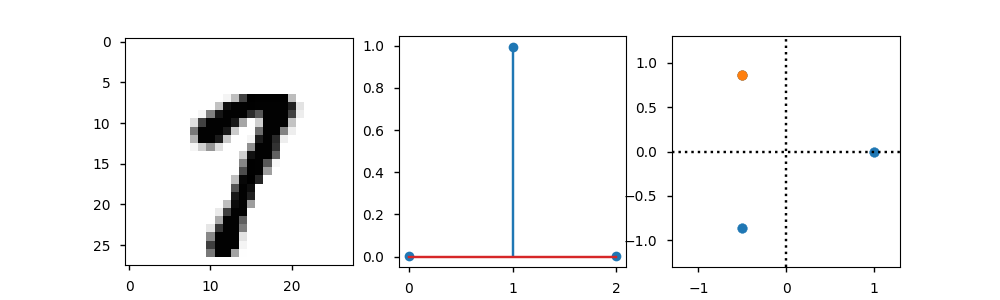

In [ ]:
#@title Visualizando desempenho do classificador e da projeção 2D no círculo
plt.close('all')
fig, axes = plt.subplots(1,3, figsize=(10,3))

i = np.random.choice(x_train.shape[0])
x = x_train[i]
y_pred = modelo_sl.predict(x.reshape(1,28,28), verbose=False)
y = y_pred.flatten()
py = np.array(cproj(y_pred)).flatten()

xt = np.arange(3)
axes[0].imshow(x, cmap='binary')
axes[1].stem(xt, y)
axes[2].axvline(0, color='k', linestyle=':')
axes[2].axhline(0, color='k', linestyle=':')
axes[2].scatter(proj[:,0], proj[:,1])
axes[2].scatter(py[0], py[1])

plt.setp(axes[1], xticks=xt)
plt.setp(axes[2], xlim=[-1.3,1.3], ylim=[-1.3,1.3])

print(f'label={y_train[i]}\npred={y}\ncoords={py}')

In [ ]:
#@title funções auxiliares (plots triangulo, relatorio comparativo, saveimg)

def plot_triangle(ax, showtext=True, showvert=True):
    arc = np.pi*(2/3)
    coords = [[1, 0],
              [np.cos(arc), np.sin(arc)],
              [np.cos(2*arc), np.sin(2*arc)],
              [1, 0]]
    coords = np.array(coords)
    ax.plot(coords[:,0], coords[:,1], ':', color='black')
    coords = np.delete(coords, (3), axis=0)

    dcolors = ['#ff5381',
               '#52c72a',
               '#3939d0']
    if(showvert):
        for i in range(3):
            ax.scatter(coords[i,0], coords[i,1],
                    marker='*',
                    s=200,
                    color=dcolors[i])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    if(showtext):
        ax.text(.98,-.13, '4', fontweight='bold', bbox=props)
        ax.text(np.cos(arc)+.06, np.sin(arc), '7', fontweight='bold', bbox=props)
        ax.text(np.cos(2*arc)+.06, np.sin(2*arc)-.05, '9', fontweight='bold', bbox=props)

    ax.set_xticks([-.5, 0, 1])
    ax.set_yticks([-.866, 0, .866])

def plot_triangle2(showtext=True):
    arc = np.pi*(2/3)
    coords = [[1, 0],
              [np.cos(arc), np.sin(arc)],
              [np.cos(2*arc), np.sin(2*arc)],
              [1, 0]]
    coords = np.array(coords)
    plt.plot(coords[:,0], coords[:,1], ':', color='black')
    coords = np.delete(coords, (3), axis=0)

    dcolors = ['#ff5381',
               '#52c72a',
               '#3939d0']
    for i in range(3):
        plt.scatter(coords[i,0], coords[i,1],
                marker='*',
                s=200,
                color=dcolors[i])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    if(showtext):
        plt.text(.98,-.13, '4', fontweight='bold', bbox=props)
        plt.text(np.cos(arc)+.06, np.sin(arc), '7', fontweight='bold', bbox=props)
        plt.text(np.cos(2*arc)+.06, np.sin(2*arc)-.05, '9', fontweight='bold', bbox=props)

    plt.xticks([-.5, 0, 1])
    plt.yticks([-.866, 0, .866])

    plt.tight_layout()

def plot_policy_report(x_orig, y_orig, pi_sl, pi_ppo, encoder, num_intervalos=4, nomes=['SL', 'RLHF'], figsize=(9,7)):
    # calcula valores
    x = tf.convert_to_tensor(x_orig, dtype=tf.float32)
    y_sl = pi_sl(x)
    y_ppo = pi_ppo(x)
    cod_sl = encoder(y_sl).numpy()
    cod_ppo = encoder(y_ppo).numpy()

    # configuracoes do grafico
    cols = num_intervalos # recontextualizando
    rows = 3 # 3 digitos
    thresholds = np.linspace(0, 1, num_intervalos+1)

    dcolors = ['#ff5381',
               '#52c72a',
               '#3939d0']
    # plot
    plt.close('all') # interactive notebook quirk
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for r in range(rows):
        idx_digit = (y_orig==r) # filtrando por digito
        for c in range(cols):
            y = y_sl[:,r] # filtrando pelo valor de pi_sl(y=digito | img)
            idx_intervalo = (thresholds[c] <= y) & (y < thresholds[c+1])
            idx = idx_digit & idx_intervalo
            axes[r,c].scatter(cod_sl[idx, 0],
                cod_sl[idx, 1],
                marker='x',
                alpha=.5,
                label=nomes[0])
            axes[r,c].scatter(cod_ppo[idx, 0],
                cod_ppo[idx, 1],
                marker='+',
                alpha=.5,
                label=nomes[1])
            plot_triangle(axes[r,c], showtext=False, showvert=False)
    for a in axes.flatten():
        a.set_xlim([-.65, 1.15])
        a.set_ylim([-1, 1])
        a.legend()
        a.set_xticks([])
        a.set_yticks([])

    digits = [4, 7, 9]
    for r in range(rows):
        axes[r,0].set_ylabel(f'Dígito={digits[r]}')

    for c in range(cols):
        axes[0,c].set_title('$\pi_{' + f'{nomes[0]}' +'} (y|x) \in$' + f'[{thresholds[c]:.2f}, {thresholds[c+1]:.2f}]', fontsize=8)
    plt.tight_layout()

def saveimg(f):
    plt.savefig(f+'.png', format='png')
    plt.savefig(f+'.jpg', format='jpg')
    plt.savefig(f+'.pdf', format='pdf')
    plt.savefig(f+'.eps', format='eps')


# print(plt.gcf().canvas.get_supported_filetypes())

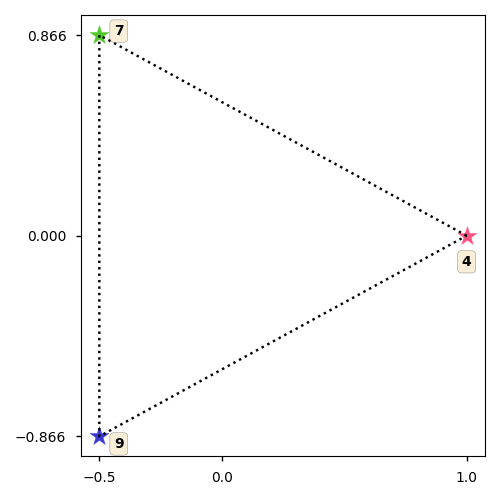

In [ ]:
# plt.close('all')
plt.figure(figsize=(5,5))
plot_triangle2()
# saveimg('imgs/diagrama-triangular')

In [ ]:
y_proj = cproj(modelo_sl(tf.convert_to_tensor(x_train))).numpy()

[]

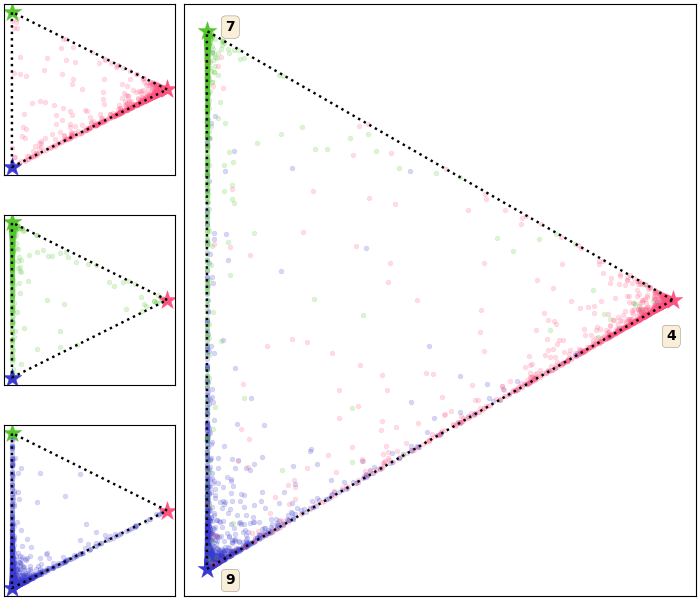

In [ ]:
## https://matplotlib.org/stable/tutorials/intermediate/arranging_axes.html

dcolors = ['#ff5381',
           '#52c72a',
           '#3939d0']

# plt.close('all')
fig = plt.figure(layout="constrained", figsize=(7,6))
gs = fig.add_gridspec(nrows=3, ncols=4, left=0.05, right=0.75,
                      hspace=0.1, wspace=0.05)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[:,1:])

sideaxes = [ax0, ax1, ax2]

for i in [2, 1, 0]:
    e =  y_proj[y_train==i]
    sideaxes[i].scatter(e[:, 0], e[:,1], marker='.', color=dcolors[i], alpha=.2)
    ax3.scatter(e[:, 0], e[:,1], marker='.', color=dcolors[i], alpha=.2)

for a in sideaxes:
    plot_triangle(a, showtext=False)
    a.set_xticks([])
    a.set_yticks([])

plot_triangle(ax3)
ax3.set_xticks([])
ax3.set_yticks([])

# saveimg('imgs/resultado-supervised')

# Etapa 2: Geração de preferências e treinamento da recompensa (via aprendizado supervisionado)

## 2.a) Gerando as anotações

1. Selecionamos dígitos que apresentaram dificuldade em serem classificados, isto é, $\pi(a|s) < p$, para um dado limiar $p$ escolhido.
2. Apresentamos a classe original e o resultado do modelo
3. Anotamos sempre a _**classe original**_ como ação _**preferencial**_

In [ ]:
# transformando em one-hot encoding (OHE)
N = y_train.shape[0]
y_train_ohe = np.zeros([N, 3])
for i in range(N):
    y_train_ohe[i, y_train[i]] = 1

# dividindo indices por digito
idx_digits = {}
for d in [0, 1, 2]:
    idx_digits[d] = (y_train==d)

### Sobre a seleção de dígitos para ajuste

- Melhor selecionar apenas um dígito de cada vez.
- Para mais de um dígito, o modelo começa a apresentar dificuldades de minimizar a perda (entropia cruzada)
- Particularmente, foi percebido um trade-off do dígito 9 vs. (4, 7)

In [ ]:
#@title selecionando dígitos para serem ajustados e limiar $p$

digitos_para_ajuste = [1] # indices (0,1,2) = digitos (4,7,9)
limiar_p = 0.7

In [ ]:
modelo_referencia = modelo_sl
# modelo_referencia = modelo_rl_7

In [ ]:
yhat = modelo_referencia(x_train).numpy()
idx_bad = []
for d in digitos_para_ajuste:
    # idx = idx_digits[d] & (yhat[:,d] < .9) & (yhat[:,d] > .1) # teste
    idx = idx_digits[d] & (yhat[:,d] < limiar_p)
    idx_bad.append(np.argwhere(idx).flatten())

print('Quantidade de dígitos abaixo do limiar de seleção p: $\pi_{ref}(a|s) < p$')
for i in idx_bad:
    print(f'{i.shape[0]}')

idx_bad_list = idx_bad
idx_bad = np.concatenate(idx_bad)

y_bad = yhat[idx_bad]
y_ref = y_train_ohe[idx_bad]
x_rlhf = x_train[idx_bad]

Quantidade de dígitos abaixo do limiar de seleção p: $\pi_{ref}(a|s) < p$
262


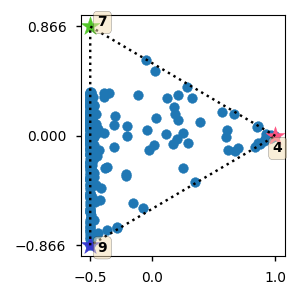

In [ ]:
#@title Visualizando digitos selecionados (projetados no espaço 2D)

# plt.close('all')
qtd_sel = len(digitos_para_ajuste)
y_proj = cproj(yhat).numpy()

if (qtd_sel > 1):
    fig, axes = plt.subplots(1,qtd_sel, figsize=(3*qtd_sel,3))
    for d in range(qtd_sel):
        idx = idx_bad_list[d]
        ax = axes.flatten()[d]
        ax.scatter(y_proj[idx, 0], y_proj[idx, 1])
        plot_triangle(ax)
    plt.tight_layout()
else:
    idx = idx_bad_list[0]
    plt.figure(figsize=(3,3))
    plt.scatter(y_proj[idx, 0], y_proj[idx, 1])
    plot_triangle2()


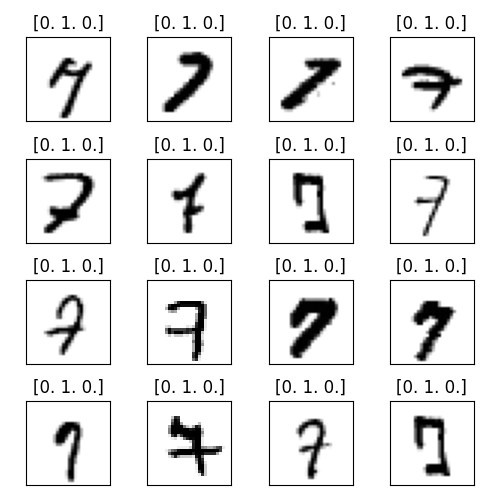

In [ ]:
#@title Visualizando dígitos selecionados (imagens)

# plt.close('all')
fig, axes = plt.subplots(4, 4, figsize=(5,5))
idx = idx_bad
for ax in axes.flatten():
    i = np.random.choice(x_train[idx].shape[0])
    ax.imshow(x_train[idx][i], cmap='binary')
    ax.set_title(f'{y_train_ohe[idx][i]}')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## 2.b) Treinando o modelo de preferencia (e o de recompensas, implicitamente)

- Formato da recompensa:
    - r(s,a) = func3( concatenate( func1(s), func2(a) ) )

- Formato da rede de preferencias:
    - softmax( r(s, a1), r(s, a2) )
    - mesmo modelo, entradas diferentes ("twin model")

---

- Referencias de implementação de código
    - "twin model"
        - https://stackoverflow.com/questions/60922607/tensorflow-2-0-how-to-implement-a-network-with-fusion-at-feature-level
    - concatenação de modelos
        - https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
        - https://stackoverflow.com/questions/43196636/how-to-concatenate-two-layers-in-keras



In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, concatenate
from tensorflow.keras.models import Model

# modelo base de recompensa
## parte da imagem (estado)
img_input = Input(shape=(28,28,1), name='img_input')
img_net = Conv2D(8, kernel_size=3, activation='relu')(img_input)
img_net = MaxPool2D((2,2))(img_net)
img_net = Conv2D(4, kernel_size=3, activation='relu')(img_net)
img_net = MaxPool2D((2,2))(img_net)
img_net = Flatten()(img_net)
# img_net = f_pre_classif(img_input)
img_net = Dense(9, activation='relu')(img_net)

## parte do codigo (ação)
cod_input = Input(shape=(3,))
cod_prep = Dense(6, activation='relu')(cod_input)

## junção das entradas e montagem do modelo de recompensa
comb_img_cod = concatenate([img_net, cod_prep])
# reward = Dense(1, activation='tanh')(comb_img_cod)
reward = Dense(1, activation='linear')(comb_img_cod)
# reward = Dense(1, activation='relu')(comb_img_cod)

modelo_recompensa = Model(inputs=[img_input, cod_input], outputs=reward)
modelo_recompensa.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 26, 26, 8)    80          ['img_input[0][0]']              
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 13, 13, 8)   0           ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 11, 11, 4)    292         ['max_pooling2d_2[0][0]']        
                                                                                              

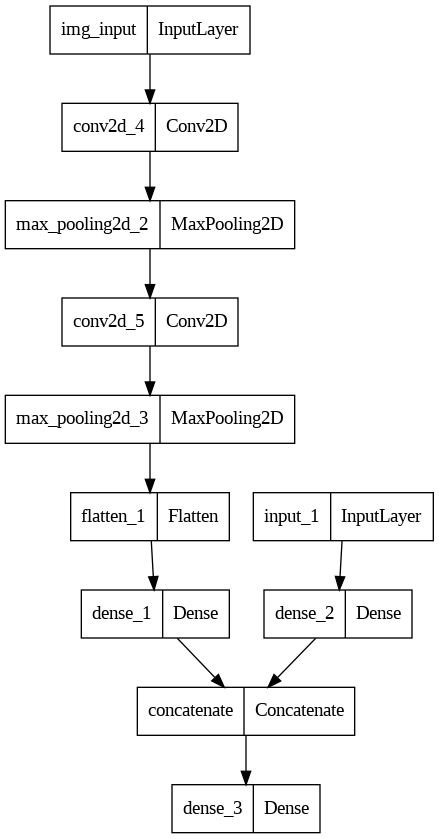

In [ ]:
tf.keras.utils.plot_model(
    modelo_recompensa,
    to_file='modelo-recompensa.png')

In [ ]:
# modelo de treino da recompensa via anotações de preferencias
## dois pares (ação, estado), A e B
imgA = Input(shape=(28,28,1), name='imgA')
codA = Input(shape=(3,), name='codA')
rewardA = modelo_recompensa([imgA, codA])

imgB = Input(shape=(28,28,1), name='imgB')
codB = Input(shape=(3,), name='codB')
# também funciona se usar o mesmo input imgA, mas fica confuso de explicar no relatório
rewardB = modelo_recompensa([imgB, codB])

## junção das recompensas numa classificação binária
prefereAB = concatenate([rewardA, rewardB])
# csm = ConstantSoftmax()
# prefereAB = csm(-prefereAB)
prefereAB = tf.nn.softmax(-prefereAB)

modelo_preferencia = Model(inputs=[imgA, codA, imgB, codB], outputs=prefereAB)
modelo_preferencia.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 imgA (InputLayer)              [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 codA (InputLayer)              [(None, 3)]          0           []                               
                                                                                                  
 imgB (InputLayer)              [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 codB (InputLayer)              [(None, 3)]          0           []                               
                                                                                            

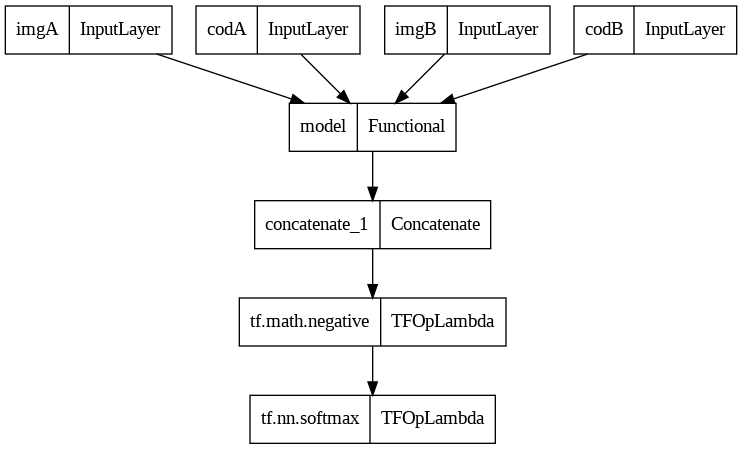

In [ ]:
tf.keras.utils.plot_model(
    modelo_preferencia,
    to_file='modelo-preferencia.png')

In [ ]:
# modelo_referencia = modelo_sl
# modelo_referencia = modelo_rl_7
yhat = modelo_referencia(x_train).numpy()
y_bad = yhat[idx_bad]
y_ref = y_train_ohe[idx_bad]
x_rlhf = x_train[idx_bad]

preferencias = np.concatenate([np.ones(y_ref.shape[0]).reshape(-1,1),
                               np.zeros(y_ref.shape[0]).reshape(-1,1)],
                              axis=1)

In [ ]:
## https://stackoverflow.com/questions/44931689/how-to-disable-printing-reports-after-each-epoch-in-keras
class PrintEpochs(tf.keras.callbacks.Callback):
    counter = 0
    def __init__(self, show_number=10, epoch=1):
        self.show_number = show_number
        self.epoch = epoch
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

    def on_train_batch_end(self, batch, logs=None):
        if self.counter == self.show_number or self.epoch == 1:
            print('Epoch: ' + str(self.epoch) + ' loss: ' + str(logs['loss']))
            if self.epoch > 1:
                self.counter = 0
        self.counter += 1

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.05)
# opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.05)

modelo_preferencia.compile(optimizer=opt, loss='categorical_crossentropy')
history = modelo_preferencia.fit([x_rlhf, y_ref, x_rlhf, y_bad], preferencias,
                          epochs=51,
                          batch_size=y_ref.shape[0],
                          verbose=0,
                          callbacks=[PrintEpochs(10)])

Epoch: 1 loss: 0.6445679664611816
Epoch: 10 loss: 0.24078479409217834
Epoch: 20 loss: 0.03613409772515297
Epoch: 30 loss: 0.00851907953619957
Epoch: 40 loss: 0.0037256930954754353
Epoch: 50 loss: 0.002399173565208912


### Depurando resultados intermediarios

Classe verdadeira:	 [0.000 1.000 0.000]
Estimativa do classificador:	 [0.002 0.439 0.560]
Recompensa estimada p/ classe verdadeira:	 [3.398]
Recompensa estimada p/ classe estimada:	 [-4.271]
Preferencia (verdadeiro, estimado):	 [9.995e-01 4.669e-04]


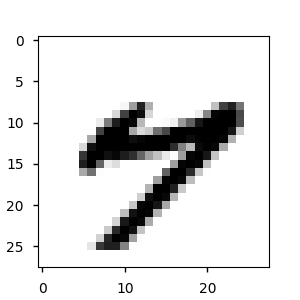

In [ ]:
i = np.random.choice(y_ref.shape[0])
yv = y_ref[i]
ye = y_bad[i]
recv = modelo_recompensa([x_rlhf[i].reshape(1,28,28), y_bad[i].reshape(1,3)]).numpy().flatten()
rece = modelo_recompensa([x_rlhf[i].reshape(1,28,28), y_ref[i].reshape(1,3)]).numpy().flatten()
prefve = modelo_preferencia([x_rlhf[i].reshape(1,28,28), y_ref[i].reshape(1,3), x_rlhf[i].reshape(1,28,28), y_bad[i].reshape(1,3)]).numpy().flatten()

vals = [yv, ye, recv, rece, prefve]
for i in range(5):
    vals[i] = np.array2string(vals[i], precision=3, floatmode='fixed')

msg = ''
msg += f'Classe verdadeira:\t {vals[0]}\n'
msg += f'Estimativa do classificador:\t {vals[1]}\n'
msg += f'Recompensa estimada p/ classe verdadeira:\t {vals[2]}\n'
msg += f'Recompensa estimada p/ classe estimada:\t {vals[3]}\n'
msg += f'Preferencia (verdadeiro, estimado):\t {vals[4]}'

print(msg)
plt.close('all')
plt.figure(figsize=(3,3));
plt.imshow(x_rlhf[i], cmap='binary');

# Etapa 3: Ajuste fino do classificador (via aprendizado por reforço)

Referências técnicas para a implementação de código:

- PPO
    - https://spinningup.openai.com/en/latest/algorithms/ppo.html
- Fine tuning
    - https://www.tensorflow.org/guide/keras/transfer_learning#fine-tuning
- Custom loss function
    - https://towardsdatascience.com/creating-custom-loss-functions-in-tensorflow-understanding-the-theory-and-practicalities-383a19e387d6?gi=19ae1acc2575
- Implementação da OpenAI de RLHF em tensorflow
    - Ziegler et. al., "Fine-Tuning Language Models from Human Preferences"
        - Paper: https://arxiv.org/abs/1909.08593
        - Código: https://github.com/openai/lm-human-preferences/blob/master/lm_human_preferences/train_policy.py#L319-L372
            - função "loss()"

- Simplificações/adaptações
    - Utiliza-se apenas a formulação básica do PPO-clip, sem as variáveis auxiliares utilizadas no framework da OpenAI
    - É usado o valor de recompensa (R) diretamente ao invés de estimar a função vantagem (A=Q-V), pois o processo sempre toma apenas uma decisão (classificação) e encerra.

In [ ]:
#@title Implementação adaptada da _loss function_ do PPO-clip
class PPOClipLoss(tf.keras.losses.Loss):
    def __init__(self, epsilon=0.2, name="ppo_clip", **kwargs):
        super().__init__(name=name, **kwargs)
        self.epsilon = epsilon

    def call(self, ratio, recompensa):
        """
        inputs:
            ratio: razao de probabilidades,
            recompensa: estimada via anotações manuais
        """
        # clip do ratio, entre [1-e, 1+e]
        ratio_clip = tf.clip_by_value(ratio, 1-self.epsilon, 1+self.epsilon)

        # objetivo = min(r, clip(r)), lower bound
        recompensa_clip = recompensa * ratio_clip
        objetivo =  tf.minimum(recompensa, recompensa_clip)

        # SGD = minimização, precisa inverter
        tf_loss = -objetivo
        return tf_loss

    def get_config(self):
        config = {
            'epsilon': self.epsilon
        }
        base_config = super().get_config()
        return {**base_config, **config}



In [ ]:
# funções auxiliares
def set_trainable(modelo):
    for l in modelo.layers:
        msg = l.name
        if l.trainable:
            msg += ':\tok'
        else:
            l.trainable = True
            msg += ':\talterado para treinável!'
        print(msg)

def copy_model(from_model, to_model):
    """ implementação:
        https://stackoverflow.com/questions/56841736/how-to-copy-a-network-in-tensorflow-2-0
    """
    for f, t in zip(from_model.variables, to_model.variables):
        t.assign(f)  # copia as variaveis de 'from_model' para 'to_model'

In [ ]:
#@title Inicialização das políticas
## esta célula funciona como RESET

# del modelo_ppo

modelo_referencia = modelo_sl
# modelo_referencia = modelo_rl_7

modelo_velho = tf.keras.models.clone_model(modelo_sl)
set_trainable(modelo_velho)
modelo_novo = tf.keras.models.clone_model(modelo_sl)
set_trainable(modelo_novo)

# copia modeloA --> modeloB
copy_model(modelo_referencia, modelo_velho)
copy_model(modelo_referencia, modelo_novo)

input_layer:	ok
conv2d:	alterado para treinável!
max_pooling2d:	alterado para treinável!
conv2d_1:	alterado para treinável!
max_pooling2d_1:	alterado para treinável!
flatten:	alterado para treinável!
dense:	alterado para treinável!
input_layer:	ok
conv2d:	alterado para treinável!
max_pooling2d:	alterado para treinável!
conv2d_1:	alterado para treinável!
max_pooling2d_1:	alterado para treinável!
flatten:	alterado para treinável!
dense:	alterado para treinável!


### configuração do PPO para otimização via tensorflow

- A função fit() otimiza uma dada função loss()
- A função loss(A,B) geralmente recebe (true, pred)
- construimos loss(A,B) da seguinte maneira:

$$A = \text{recompensa}(s, \pi_{velho}(s))$$

$$B = \frac{\pi_{novo}(a|s)}{\pi_{velho}(a|s)}$$

$$loss(A,B) = - \min (A, clip(A.B, 1-\epsilon, 1+\epsilon))$$

- O coeficiente $\epsilon$ é determinado na criação da instância da classe PPOClipLoss(), com valor padrão igual a 0,2.


In [ ]:
# entradas
img = Input(shape=(28,28,1), name='imagem')
pi_velho = Input(shape=(3,), name='y_velho')

# rede auxiliar
pi_novo = modelo_novo(img) ## imbutindo o modelo mais novo na função custo
amax = tf.argmax(pi_novo, axis=1)[0]
prob_novo = pi_novo[0, amax]
prob_velho = pi_velho[0, amax]
ratio = prob_novo / prob_velho # razao de probabilidades

# modelo para treinar
modelo_ppo = Model(inputs=[img, pi_velho], outputs=ratio)
modelo_ppo.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 imagem (InputLayer)            [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 classifier_net (Functional)    (None, 3)            675         ['imagem[0][0]']                 
                                                                                                  
 tf.math.argmax_2 (TFOpLambda)  (None,)              0           ['classifier_net[0][0]']         
                                                                                                  
 tf.__operators__.getitem_6 (Sl  ()                  0           ['tf.math.argmax_2[0][0]']       
 icingOpLambda)                                                                             

esta figura ficou muito confusa!
no relatório foi melhor descrever textualmente


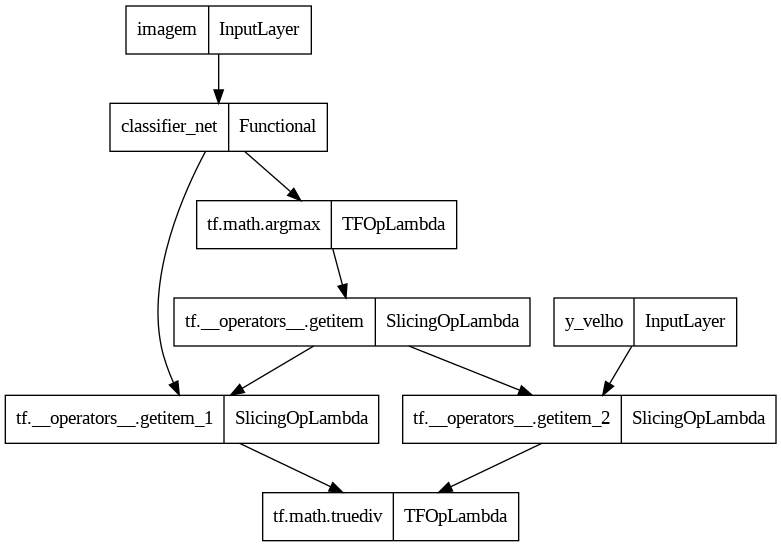

In [ ]:
msg = 'esta figura ficou muito confusa!\n'
msg += 'no relatório foi melhor descrever textualmente'
print(msg)

tf.keras.utils.plot_model(
    modelo_ppo,
    to_file='modelo-ppo.png')

In [ ]:
# simulando dados de entrada
# x_input = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_input = tf.convert_to_tensor(x_rlhf, dtype=tf.float32)

In [ ]:
# setup treinamento PPO
ppo_clip_loss = PPOClipLoss(epsilon=0.2) # loss(ratio, recompensa)

opt = tf.keras.optimizers.Adam(learning_rate=9e-5)
# opt = tf.keras.optimizers.Nadam(learning_rate=9e-5)
# opt = tf.keras.optimizers.experimental.AdamW(learning_rate=8e-5)

modelo_ppo.compile(optimizer=opt, loss=ppo_clip_loss)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    verbose=0,
    restore_best_weights=True,
)

## Ciclo de treinamento de aprendizado por reforço

Primeira passagem:
- executa UPDATE e TREINO

Resto do treinamento:
- idealmente, itera entre TREINO e UPDATE
- se precisar, executa ROLLBACK

A "função plot_policy_report()" permite verificar a mudança de comportamento do classificador em relação ao anterior.


In [ ]:
#@title UPDATE
## UPDATE modelo / se o modelo estiver bom
copy_model(modelo_novo, modelo_velho) # novo := velho
y_velho = modelo_velho(x_input)
recompensas = modelo_recompensa([x_input, y_velho])
recompensas -= tf.reduce_mean(recompensas) # Schuman et. al., PPO

In [ ]:
#@title ROLLBACK
## ROLLBACK modelo / caso tenha ocorrido algum problema
copy_model(modelo_velho, modelo_novo)

In [ ]:
#@title TREINO
## TREINA modelo / processo de minimização (menor = melhor)
history = modelo_ppo.fit(
    [x_input, y_velho],
    recompensas,
    epochs=3,
    # batch_size=iny_velho.shape[0],
    batch_size=32,
    # verbose=0,
    # callbacks=[PrintEpochs()] # PrintEpochs(), early_stop
)

Epoch 1/3
9/9 [==============================] - 0s 6ms/step - loss: -0.8833
Epoch 2/3
9/9 [==============================] - 0s 5ms/step - loss: -0.9300
Epoch 3/3
9/9 [==============================] - 0s 5ms/step - loss: -0.9689


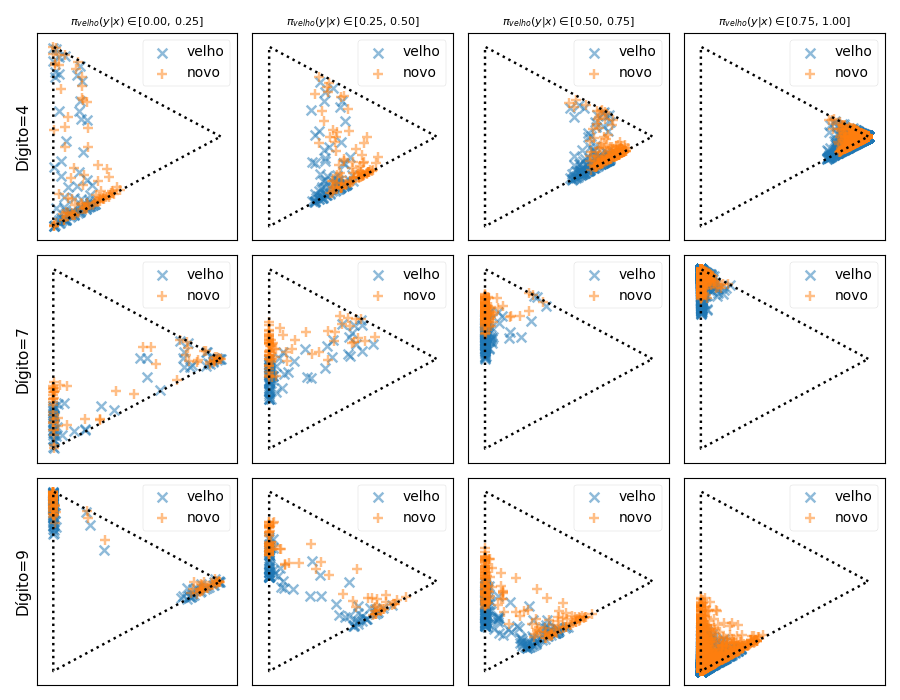

In [ ]:
#@title Verificando resultados imediatos
plot_policy_report(x_train,
                   y_train,
                   modelo_velho,
                   modelo_novo,
                   cproj,
                   num_intervalos=4,
                   nomes = ['velho', 'novo'])

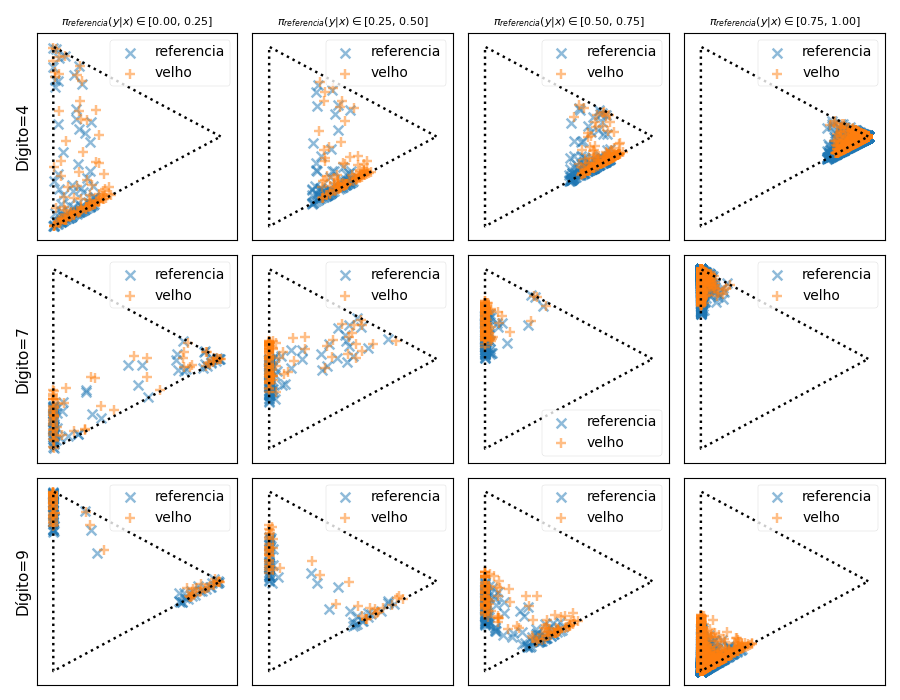

In [ ]:
#@title Verificando desempenho em relação ao modelo inicial
plot_policy_report(x_train,
                   y_train,
                   modelo_referencia,
                   modelo_velho,
                   cproj,
                   num_intervalos=4,
                   nomes=['referencia', 'velho'])

### Após o treino

- Depois do treinamento, podemos iterar entre as Etapas 2 e 3
- Isso permite o ajuste incremental do classificador
- x

In [ ]:
#@title Grava resultados
# m = modelo_rlhf
# m.save('nome_modelo')

# Resultados apresentados no relatório final

In [ ]:
!unzip modelos_salvos.zip

Archive:  modelos_salvos.zip
replace f_classif_rlhf_7/fingerprint.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: f_classif_rlhf_7/fingerprint.pb  
  inflating: f_classif_rlhf_7/keras_metadata.pb  
  inflating: f_classif_rlhf_7/saved_model.pb  
  inflating: f_classif_rlhf_7/variables/variables.data-00000-of-00001  
  inflating: f_classif_rlhf_7/variables/variables.index  
 extracting: f_classif_rlhf_7_9/fingerprint.pb  
  inflating: f_classif_rlhf_7_9/keras_metadata.pb  
  inflating: f_classif_rlhf_7_9/saved_model.pb  
  inflating: f_classif_rlhf_7_9/variables/variables.data-00000-of-00001  
  inflating: f_classif_rlhf_7_9/variables/variables.index  
   creating: f_classif_supervised/assets/
 extracting: f_classif_supervised/fingerprint.pb  
  inflating: f_classif_supervised/keras_metadata.pb  
  inflating: f_classif_supervised/saved_model.pb  
   creating: f_classif_supervised/variables/
  inflating: f_classif_supervised/variables/variables.data-00000-of-00001  
  inflating: 

In [ ]:
modelo_sl_relatorio = tf.keras.models.load_model('f_classif_supervised/')
modelo_rl_7_relatorio = tf.keras.models.load_model('f_classif_rlhf_7/')
modelo_rl_7_9_relatorio = tf.keras.models.load_model('f_classif_rlhf_7_9/')

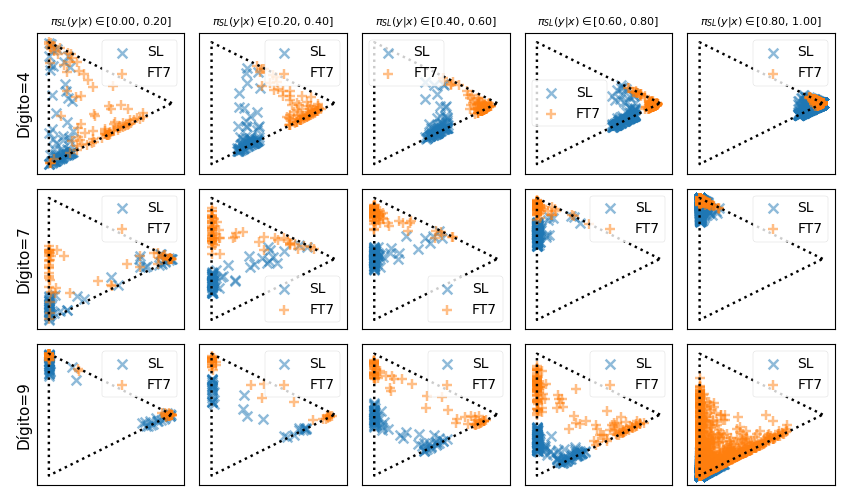

In [ ]:
plot_policy_report(x_train,
                   y_train,
                   modelo_sl_relatorio,
                   modelo_rl_7_relatorio,
                   cproj,
                   num_intervalos=5,
                   figsize=(8.5,5),
                   nomes=['SL', 'FT7'])
# saveimg('imgs/resultado-rlhf-7')

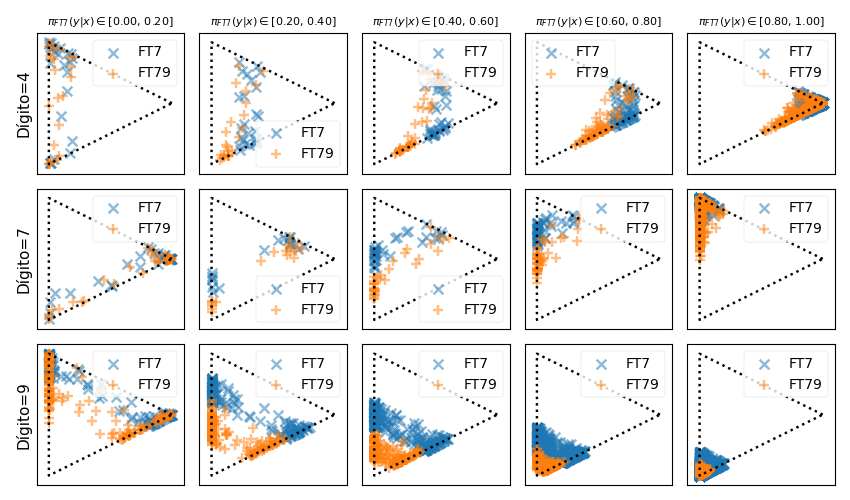

In [ ]:
plot_policy_report(x_train,
                   y_train,
                   modelo_rl_7_relatorio,
                   modelo_rl_7_9_relatorio,
                   cproj,
                   num_intervalos=5,
                   figsize=(8.5,5),
                   nomes=['FT7', 'FT79'])
# saveimg('imgs/resultado-rlhf-7-9')